In [18]:
import numpy as np 
import cv2
from matplotlib import pyplot as plt
import requests
import time
import coolors
from IPython.core.display import display, HTML, clear_output
from colormath.color_objects import sRGBColor, LabColor
from colormath.color_diff import delta_e_cie2000
from colormath.color_conversions import convert_color
import nest_asyncio


In [47]:
def imshow(*args):
    rgb_imgs = [cv2.cvtColor(img,cv2.COLOR_BGR2RGB) for img in args]
    complete_img = np.hstack(tuple(rgb_imgs))
    plt.imshow(complete_img)
    plt.xticks([]), plt.yticks([])  # Hides the graph ticks and x / y axis
    plt.show()
    
def print_progress(amnt):
    clear_output(wait = True)
    print(f"{'%.2f'%(100* amnt)}%")

def disp_color(color):
    return f'<div style = "width: 100px; height:100px; background-color:{color}">{color}</div>'

def display_colors(colors):
    color_html="".join([disp_color('#'+color) for color in hex_colors])
    color_html = f'<div style = " display: flex;">{color_html}</div>'
    display(HTML(color_html))
    
    
def hex_to_rgb(value):
    value = value.lstrip('#')
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


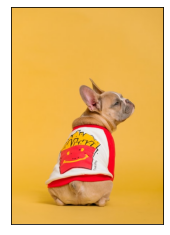

In [13]:
# pulls a random image from unspalsh by changing size and theme can change what image is pulled
size = '420x600'
theme = "dog"
url=f'https://source.unsplash.com/{size}/?{theme}'
resp = requests.get(url, stream=True).raw
img = np.asarray(bytearray(resp.read()), dtype="uint8")
img = cv2.imdecode(img, cv2.IMREAD_COLOR)

imshow(img)

In [4]:
# generates a random color scheme by scraping https://coolors.co
nest_asyncio.apply()
hex_colors = coolors.generate()
display_colors(hex_colors)

In [5]:
#convert hex to rgb
rgb_color_scheme= [hex_to_rgb(color) for color in hex_colors]
#convert rgb to Color Objects 
srgb_color_scheme = [sRGBColor(*color,True) for color in rgb_color_scheme]
#convert srgb to LAB
lab_color_scheme = [convert_color(color, LabColor) for color in srgb_color_scheme ]

In [6]:
# make a copy of the image with all zeros in it to write our new image into 
palleted_img = np.zeros(img.shape, 'uint8')

In [ ]:
h = img.shape[0]
w = img.shape[1]
#iterates through the image and finds the closest color in the color pallete
for i in range(h):
    print_progress(i/(h-1)
    for j in range(w):
        # finds the bgr value of our current pixel
        bgr = img[i,j,:]
        
        #converts bgr to lab
        srgb = sRGBColor(bgr[2],bgr[1],bgr[0],True)
        lab = convert_color(srgb, LabColor)
        
        # checks each color in our color pallete for the closest color
        arr = [delta_e_cie2000(lab, color) for color in lab_color_scheme]
        idx = np.where(arr == np.min(arr))[0][0]
        closest = rgb_color_scheme[idx]
        # sets creates a new image with our colors
        palleted_img[i,j,0] = closest[2]
        palleted_img[i,j,1] = closest[1]
        palleted_img[i,j,2] = closest[0]
        
imshow(palleted_img)

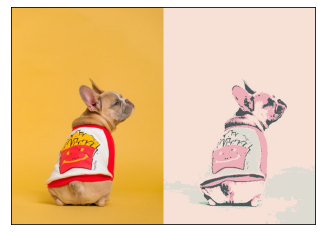

In [31]:
#shows color pallete and before and after image
display_colors(hex_colors)
imshow(img,palleted_img)

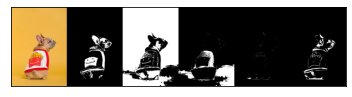

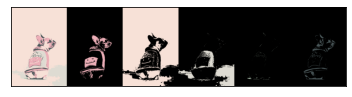

In [48]:
#break up each image into a set of x masks 1 for each color in our color pallete
masks = [img]
outputs = [palleted_img]
for color in rgb_color_scheme: 
    
    color = list(color)
    color.reverse()
    lower = np.array(color, dtype = "uint8")
    upper = np.array(color, dtype = "uint8")
    
    mask = cv2.inRange(palleted_img, lower, upper)
    output = cv2.bitwise_and(palleted_img, palleted_img, mask = mask)
    
    masks.append(mask)
    outputs.append(output)
    
imshow(*masks)
imshow(*outputs)